# Data Integrity Check


Comparison between python extracted data vs matlab extracted data.

In [4]:
# Relevant imports

import os
import re
import pandas as pd
import pickle
import random
import pydicom
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import seaborn as sns

In [5]:
# Pulling python dataframe 

df_fibrosis = pd.read_pickle(r'..\..\..\\fibrosis_data.pkl')
df_fibrosis = df_fibrosis.drop(columns=["SliceData"])
df_fibrosis.head(10)

,SliceID,Class
0,101__CT-0002-0001,0
1,101__CT-0002-0002,0
2,101__CT-0002-0003,0
3,101__CT-0002-0004,0
4,101__CT-0002-0005,0
5,101__CT-0002-0006,1
6,101__CT-0002-0007,0
7,101__CT-0002-0008,1
8,101__CT-0002-0009,0
9,101__CT-0002-0010,0


In [6]:
# Pulling matlab dataframe 

df_matlab = pd.read_excel('outputCSV.xlsx')
df_matlab = df_matlab.drop(columns=['class1','class2', 'class3', 'class4', 'class5'])
df_matlab.tail(10)

,filename,class0
3039,211_4647_0021,0
3040,211_4647_0022,0
3041,211_4647_0023,0
3042,211_4647_0024,0
3043,211_4647_0025,0
3044,211_4647_0026,0
3045,211_4647_0027,0
3046,211_4647_0028,0
3047,211_4647_0029,0
3048,211_4647_0030,0


# Preliminary Analysis

I won't be performing any type of specific statystical analysis here, since features will be derived by CNN. Instead, I will be focusing on normalization and augmentation, with the intent of enhancing algortihm performance.

In [7]:
# General overview
print("\nGeneral overview:")
df_fibrosis.info()


General overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3075 entries, 0 to 3074
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   SliceID  3075 non-null   object
 1   Class    3075 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 48.2+ KB


In [8]:
# General overview
print("\nGeneral overview:")
df_matlab.info()


General overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3049 entries, 0 to 3048
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  3049 non-null   object
 1   class0    3049 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 47.8+ KB


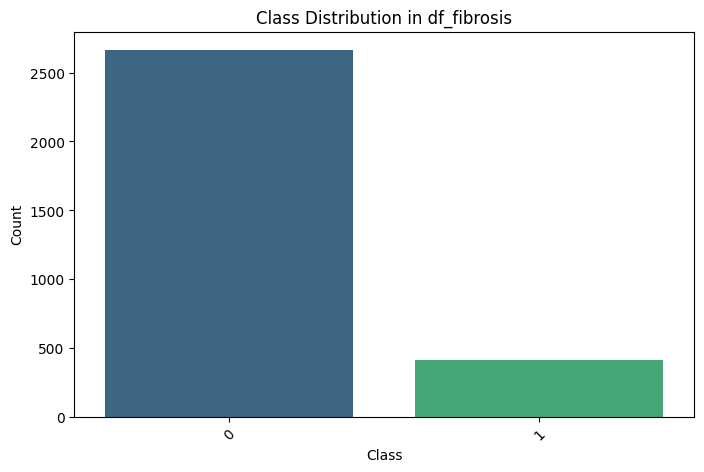

Class
0    86.699187
1    13.300813
Name: count, dtype: float64
Class
0    2666
1     409
Name: count, dtype: int64


In [9]:
# Plots class counts
plt.figure(figsize=(8, 5))
sns.countplot(data=df_fibrosis, x='Class', hue="Class", palette='viridis', legend=False)

plt.title('Class Distribution in df_fibrosis')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45)  
plt.show()


# Displays imbalance
class_counts, total_samples = df_fibrosis['Class'].value_counts(), len(df_fibrosis)
print((class_counts / total_samples) * 100)
print(class_counts)

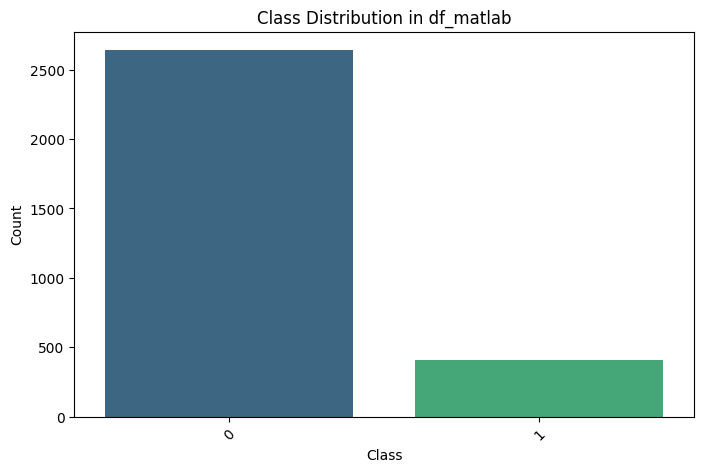

class0
0    86.651361
1    13.348639
Name: count, dtype: float64
class0
0    2642
1     407
Name: count, dtype: int64


In [10]:
# Plots class counts
plt.figure(figsize=(8, 5))
sns.countplot(data=df_matlab, x='class0', hue="class0", palette='viridis', legend=False)

plt.title('Class Distribution in df_matlab')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45)  
plt.show()


# Displays imbalance
class_counts, total_samples = df_matlab['class0'].value_counts(), len(df_matlab)
print((class_counts / total_samples) * 100)
print(class_counts)

## HRCT

It is also important to verify if the predefined test split shares the same data proportion, for result validity:

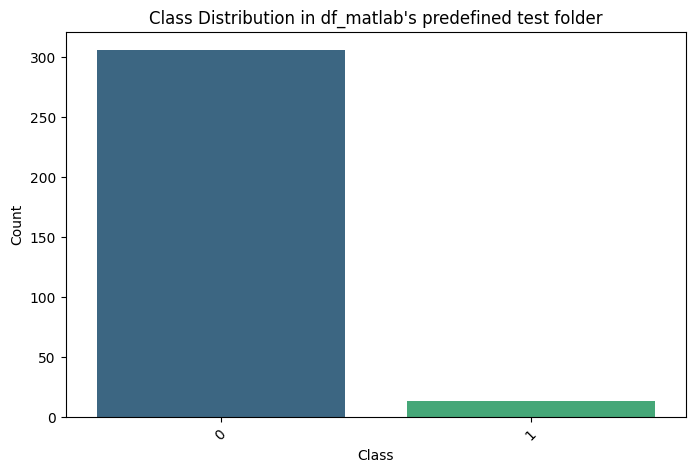

class0
0    95.924765
1     4.075235
Name: count, dtype: float64
class0
0    306
1     13
Name: count, dtype: int64


In [56]:
df_fibrosis_test = df_matlab[df_matlab['filename'].str.startswith(r'2')]

# Plots class counts
plt.figure(figsize=(8, 5))
sns.countplot(data=df_fibrosis_test, x='class0', hue="class0", palette='viridis', legend=False)

plt.title('Class Distribution in df_matlab\'s predefined test folder')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45)  
plt.show()


# Displays imbalance
class_counts, total_samples = df_fibrosis_test['class0'].value_counts(), len(df_fibrosis_test)
print((class_counts / total_samples) * 100)
print(class_counts)

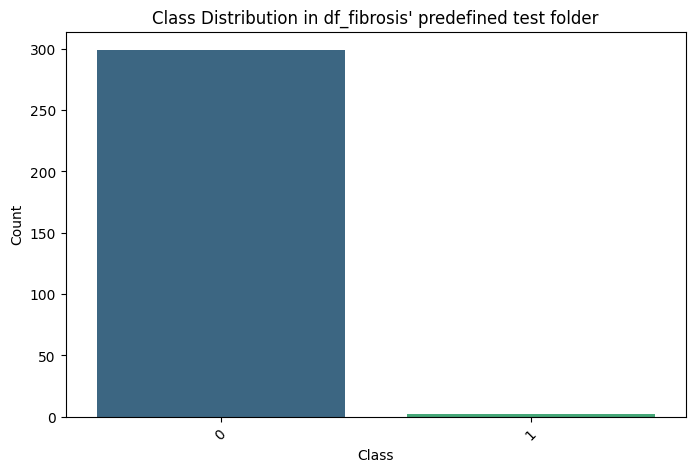

Class
0    99.335548
1     0.664452
Name: count, dtype: float64
Class
0    299
1      2
Name: count, dtype: int64


In [57]:
df_fibrosis_test = df_fibrosis[df_fibrosis["SliceID"].str.contains("HRCT_Pilot")]

# Plots class counts
plt.figure(figsize=(8, 5))
sns.countplot(data=df_fibrosis_test, x='Class', hue="Class", palette='viridis', legend=False)

plt.title('Class Distribution in df_fibrosis\' predefined test folder')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45)  
plt.show()


# Displays imbalance
class_counts, total_samples = df_fibrosis_test['Class'].value_counts(), len(df_fibrosis_test)
print((class_counts / total_samples) * 100)
print(class_counts)

## Manual Confirmation

In [68]:
import pandas as pd
import re

# --- Step 1: df_matlab filtering and sorting ---
df1 = df_matlab[df_matlab['class0'] == 1].copy()

def parse_filename(name):
    parts = list(map(int, name.split('_')))
    return parts

df1['sort_key'] = df1['filename'].apply(parse_filename)
df1 = df1.sort_values('sort_key')
df1_filenames = df1['filename'].reset_index(drop=True)

# --- Step 2: df_fibrosis filtering and sorting ---
df2 = df_fibrosis[df_fibrosis['Class'] == 1].copy()

def parse_slice_id(slice_id):
    # Extract all numbers for primary sort
    all_numbers = list(map(int, re.findall(r'\d+', slice_id)))
    first_number = all_numbers[0] if all_numbers else -1

    # Extract part after the last "__"
    tail = slice_id.split('__')[-1]

    # Split using both '-' and '.'
    split_tail = re.split(r'[-\.]', tail)
    tail_numbers = [int(num) for num in split_tail if num.isdigit()]

    # Get second-to-last and last number if available
    second_last = tail_numbers[-2] if len(tail_numbers) >= 2 else -1
    last = tail_numbers[-1] if len(tail_numbers) >= 1 else -1

    return (first_number, second_last, last)



df2['sort_key'] = df2['SliceID'].apply(parse_slice_id)
df2 = df2.sort_values('sort_key')
df2_slice_ids = df2['SliceID'].reset_index(drop=True)

# --- Step 3: Combine and save ---
combined_df = pd.DataFrame({
    'filename': df1_filenames,
    'SliceID': df2_slice_ids
})

combined_df.to_csv('matched_output.csv', index=False)


In [73]:
df_fibrosis[df_fibrosis["SliceID"] == "8__CT-INSPIRIUM-8873__CT-8873-0012"]

,SliceID,Class
2766,8__CT-INSPIRIUM-8873__CT-8873-0012,0


---

## Adapted MatLab code


In [ ]:

def load_roi_files(roi_file_name):
    # List to store all the ROIs
    rois = []

    # Open the ROI file for reading
    with open(roi_file_name, 'r') as file:
        roi = {}
        while True:
            # Read a line from the file
            line = file.readline()
            
            # Stop if we reach the end of the file
            if not line:
                break

            # Check and parse each line based on its prefix
            if 'label:' in line:
                roi['label'] = line.replace('label: ', '').strip()
            elif 'slice_number:' in line:
                roi['slice_number'] = float(line.replace('slice_number: ', '').strip())

                # Append the parsed ROI to the list of ROIs
                rois.append(roi)
                roi = {}  # Reset for the next ROI

    return rois

In [ ]:
load_roi_files(r"C:\Users\hasht\Desktop\Cloned Repositories\fibrosis_dataset\ILD_DB_txtROIs\8\CT-INSPIRIUM-8873\CT-INSPIRIUM-8873.txt")

[{'label': 'bronchiectasis', 'slice_number': 9.0},
 {'slice_number': 11.0},
 {'slice_number': 12.0},
 {'label': 'fibrosis', 'slice_number': 3.0},
 {'slice_number': 4.0},
 {'slice_number': 5.0},
 {'slice_number': 8.0},
 {'slice_number': 9.0},
 {'slice_number': 10.0},
 {'slice_number': 11.0},
 {'slice_number': 13.0},
 {'slice_number': 14.0},
 {'slice_number': 15.0}]

In [ ]:
# Recursively search a folder for .txt files and load ROI data from them
def search_and_load_roi_files(folder):
    for root, dirs, files in os.walk(folder):  # Walk through all subdirectories
        folder_name = os.path.basename(root)  # Get the folder name, not the whole directory path
        print(f"Searching in folder: {folder_name}")  # Print the current folder
        
        for file in files:
            if file.endswith(".txt"):  # Check if the file is a .txt file
                txt_file_path = os.path.join(root, file)
                print(f"Found txt file: {file}")  # Print the txt file found
                
                # Load the ROIs for the current txt file
                rois = load_roi_files(txt_file_path)
                print(f"Loaded ROIs from {file}: {rois}")  # Print the loaded ROIs
                print("\n" + "="*50 + "\n")  # Separator for clarity

# Example usage
folder_to_search = r'C:\Users\hasht\Desktop\Cloned Repositories\fibrosis_dataset\ILD_DB_txtROIs\HRCT_pilot'  # Replace with your folder path
search_and_load_roi_files(folder_to_search)

Searching in folder: HRCT_pilot
Searching in folder: 200
Found txt file: CT-0002.txt
Loaded ROIs from CT-0002.txt: [{'label': 'healthy', 'slice_number': 5.0}, {'slice_number': 9.0}, {'slice_number': 12.0}, {'slice_number': 15.0}]


Searching in folder: 201
Found txt file: CT-0002.txt
Loaded ROIs from CT-0002.txt: [{'label': 'micronodules', 'slice_number': 5.0}, {'slice_number': 9.0}, {'slice_number': 15.0}]


Searching in folder: 203
Found txt file: CT-7800.txt
Loaded ROIs from CT-7800.txt: [{'label': 'healthy', 'slice_number': 10.0}, {'label': 'fibrosis', 'slice_number': 15.0}, {'slice_number': 17.0}]


Searching in folder: 204
Found txt file: CT-3962.txt
Loaded ROIs from CT-3962.txt: [{'label': 'healthy', 'slice_number': 7.0}, {'slice_number': 13.0}, {'slice_number': 17.0}, {'slice_number': 18.0}, {'slice_number': 22.0}, {'slice_number': 23.0}, {'label': 'bronchiectasis', 'slice_number': 17.0}, {'slice_number': 18.0}]


Searching in folder: 205
Found txt file: CT-0002.txt
Loaded ROIs